In [1]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
data = pd.read_csv('bitcoin-train.csv')
data=data.iloc[::-1]
data.index=pd.date_range('2013-04-28','2017-7-31')
data=data.drop(['Date','Volume','Market Cap'],axis=1)


In [3]:
#GET the moving average of the training set
x=data['High']
cols, names = [], []
dim=4
for i in range(1, 0, -1):
        cols.append(data.shift(i))
        names += [('T%d(t-%d)' % (j+1, i)) for j in range(dim)]
for i in range(0, 1):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('T%d(t)' % (j+1)) for j in range(dim)]
        else:
            names += [('T%d(t+%d)' % (j+1, i)) for j in range(dim)]
x = pd.concat(cols, axis=1)#merge them togehter
x.columns = names
x.dropna(inplace=True)
x=x.drop(['T2(t-1)'],axis=1)

In [4]:
y=data['High']

# scale x
x_scaler = MinMaxScaler().fit(x)
x = x_scaler.transform(x) 

# scale target value
y_scaler = MinMaxScaler().fit(y.values.reshape(-1,1))
y = y_scaler.transform(y.values.reshape(-1,1))

In [5]:
num_periods = 20 #we divide the whole dataset into 20 period
f_horizon = 1  #forecast next period

x_train = x[:(len(x)-(len(x) % num_periods))] 
x_batches = x_train.reshape(-1, 20, 7) #get the training set 7 is the dimension of training x

y_train = y[:(len(y)-(len(y) % num_periods))]
y_batches = y_train.reshape(-1, 20, 1)#get the training true value
#get the test set
test_x_setup = x[-(num_periods + f_horizon):]
test_x = test_x_setup[:num_periods].reshape(-1, 20, 7)
test_y = y[-(num_periods):].reshape(-1, 20, 1)

In [6]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 7         #number of vectors submitted 
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

#set the learning rate
learning_rate = 0.001   

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 
init = tf.global_variables_initializer()

In [7]:
epochs = 200   #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
trainloss=[]
with tf.Session() as sess:
    init.run()
    ans=[]
    for ep in range(epochs):
        ans=sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
        trainloss.append(mse)#get loss function
    test_pred = sess.run(outputs, feed_dict={X: test_x}) #get test result
    train_pred = sess.run(outputs, feed_dict={X: x_batches})#get train result
    

In [8]:
test_pred = y_scaler.inverse_transform(test_pred.reshape(1, -1)).reshape(-1,)
test_true = y_scaler.inverse_transform(test_y.reshape(1, -1)).reshape(-1,)

In [9]:
train_pred = y_scaler.inverse_transform(train_pred.reshape(1, -1)).reshape(-1,)
train_true = y_scaler.inverse_transform(y_train.reshape(1, -1)).reshape(-1,)

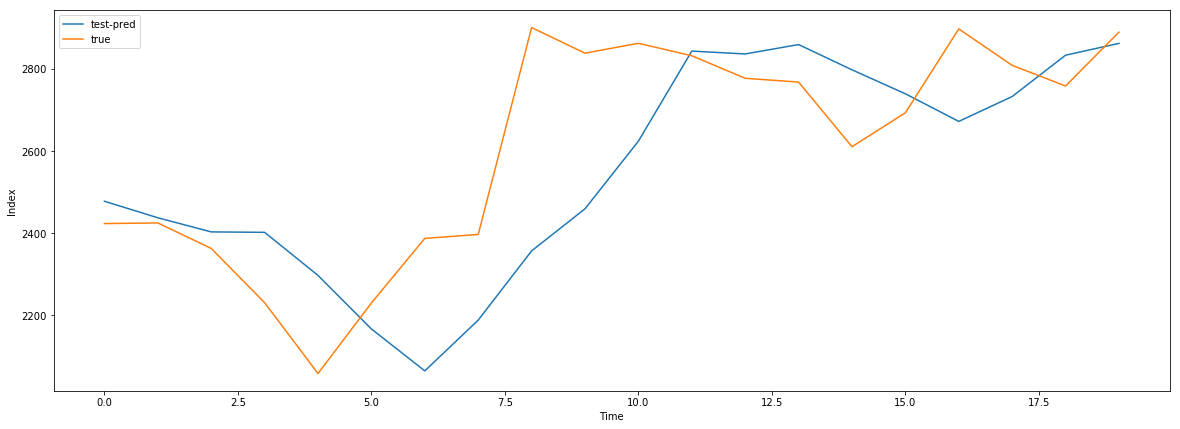

In [10]:
plt.figure(figsize=(20, 7))
plt.xlabel('Time')
plt.ylabel('Index')
plt.plot(test_pred, label='test-pred')
plt.plot(test_true, label='true')
plt.legend()
plt.show()

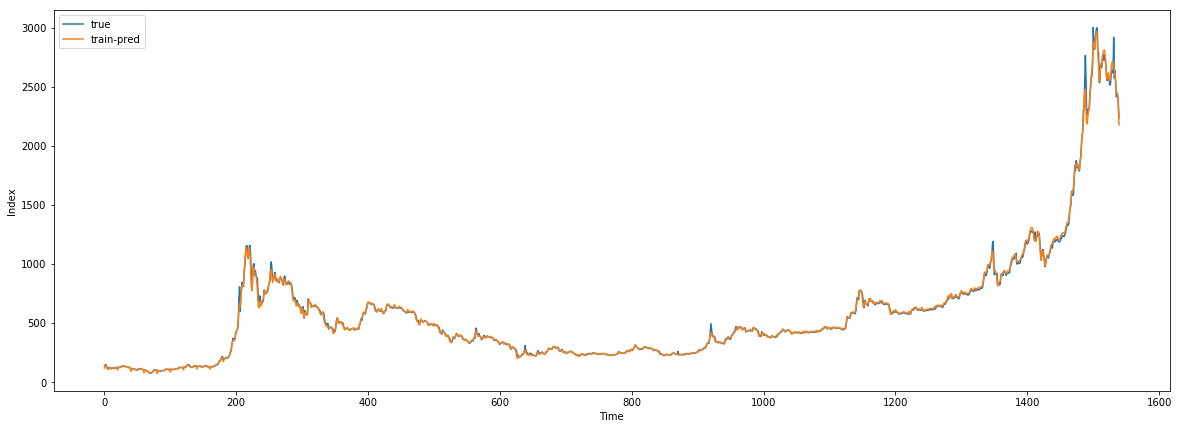

In [11]:
plt.figure(figsize=(20, 7))
plt.xlabel('Time')
plt.ylabel('Index')
plt.plot(train_true, label='true')
plt.plot(train_pred, label='train-pred')
plt.legend()
plt.show()

In [12]:
#test  error
MSE = ((test_true-test_pred)**2).sum()/test_true.size
RMSE = np.sqrt(((test_true-test_pred)**2).sum()/test_true.size)
MAE= (np.abs(test_true-test_pred)).sum()/test_true.size
MAPE=(np.abs(test_true-test_pred)*100/test_true).sum()/test_true.size
print(RMSE,MAE,MAPE)

206.16562924730854 153.51486035156248 5.901219041524737


In [13]:
#train error
MSE = ((train_true-train_pred)**2).sum()/train_true.size
RMSE = np.sqrt(((train_true-train_pred)**2).sum()/train_true.size)
MAE= (np.abs(train_true-train_pred)).sum()/train_true.size
MAPE=(np.abs(train_true-train_pred)*100/train_true).sum()/train_true.size
print(RMSE,MAE,MAPE)

20.869360832070615 9.970047423127411 1.690507104040788


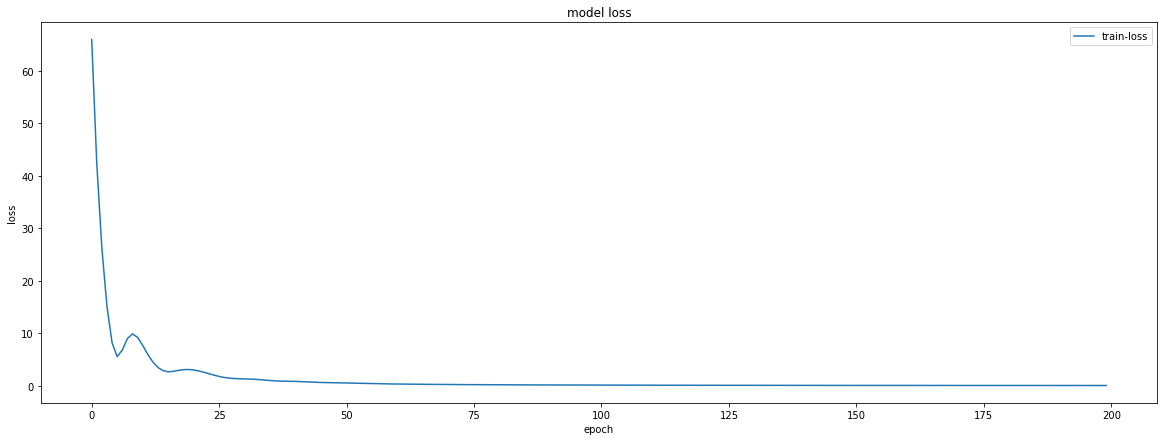

In [14]:
#plot train loss
plt.figure(figsize=(20, 7))
plt.plot(trainloss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss'], loc='upper right')
plt.show()